##### Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

##### Read the data

In [4]:
# Read the dataset
df = pd.read_csv('../../data/Amazon.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Returned
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


##### Formulate the data (separate X, y and split into train/val/test)

In [5]:
# Separate features and target
X = df.drop(columns=['ID', 'Returned'])
y = df['Returned']

# Train, validation, and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (7039, 10), Validation shape: (1760, 10), Test shape: (2200, 10)


##### Encoding categorical variables (Target Encoding)

In [6]:
# Apply Target Encoding
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)


##### Feature Scaling

In [7]:
# Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

##### Regularization and building the NN model

In [8]:
# Define Regularization
L2reg = tf.keras.regularizers.l2(l2=1e-2)

# Create Sequential model
model = Sequential()
model.add(Dense(256, kernel_regularizer=L2reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=L2reg))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64, kernel_regularizer=L2reg))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


2025-04-26 21:24:19.035889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Early stopping callback

In [12]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

##### Train the model

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6769 - loss: 0.5352 - val_accuracy: 0.6528 - val_loss: 0.5602
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6759 - loss: 0.5428 - val_accuracy: 0.6506 - val_loss: 0.5603
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6769 - loss: 0.5450 - val_accuracy: 0.6528 - val_loss: 0.5630
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6766 - loss: 0.5283 - val_accuracy: 0.6551 - val_loss: 0.5594
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6828 - loss: 0.5322 - val_accuracy: 0.6455 - val_loss: 0.5576
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6728 - loss: 0.5316 - val_accuracy: 0.6523 - val_loss: 0.5571
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6831 - loss: 0.5347 - val_accuracy: 0.6483 - val_loss: 0.5629
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6797 - loss: 0.5331 - val_accuracy: 0.6375 - val_loss:

##### Evaluate the model on test set

In [14]:
# Evaluate model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6846 - loss: 0.5283
Test Loss: 0.5309
Test Accuracy: 0.6791


##### Train vs validation accuracy

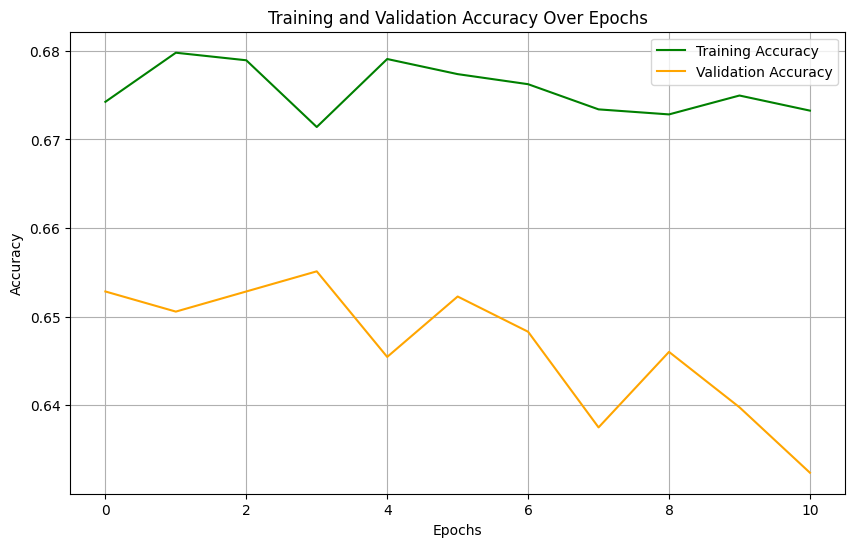

In [16]:
# Extract accuracy and validation accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()